# PaySim 금융 사기 탐지
### 📓 03. 전처리 · 피처 엔지니어링 · 패턴 검증(The "How" & "Proof")

02_eda에서 수립한 가설을 실제 데이터로 구현하고, 우리가 설계한 파생변수가 진짜 효과가 있는지 시각적으로 증명한다.

본 노트북의 흐름은 다음과 같다.

3. 데이터 전처리 (The "How"): EDA 결론을 바탕으로 불필요한 데이터를 제거하고, 0으로 위장된 잠재적 결측치를 처리한다.

4. Feature Engineering: 가설에서 도출한 errorBalanceOrig, errorBalanceDest 파생변수를 실제로 생성한다.

5. 패턴 검증 시각화 (The "Proof"): 만든 변수가 실제로 사기와 정상을 분리하는지 히트맵과 3D 산점도로 증명한다.

#### 0. 라이브러리 및 데이터 로드

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

%matplotlib inline
plt.style.use("seaborn-v0_8")

import warnings
warnings.filterwarnings("ignore")


pd.options.display.float_format = '{:,.0f}'.format

df = pd.read_csv("../data/raw/paysim.csv")

df = df.rename(columns={
    "oldbalanceOrg": "oldBalanceOrig",
    "newbalanceOrig": "newBalanceOrig",
    "oldbalanceDest": "oldBalanceDest",
    "newbalanceDest": "newBalanceDest"
})

df.head()


,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,"9,840",C1231006815,"170,136","160,296",M1979787155,0,0,0,0
1,1,PAYMENT,"1,864",C1666544295,"21,249","19,385",M2044282225,0,0,0,0
2,1,TRANSFER,181,C1305486145,181,0,C553264065,0,0,1,0
3,1,CASH_OUT,181,C840083671,181,0,C38997010,"21,182",0,1,0
4,1,PAYMENT,"11,668",C2048537720,"41,554","29,886",M1230701703,0,0,0,0


#### 3. 데이터 전처리 (Data Cleaning)
##### 3-1. 분석 대상 필터링 및 불필요 피처 제거
02_eda에서 확인했듯, 사기는 TRANSFER와 CASH_OUT에서만 발생한다. 

나머지 거래 유형은 분석 대상에서 제외하고, 정보량이 없는 피처(nameOrig, nameDest, isFlaggedFraud)도 함께 삭제한다.

In [6]:
# TRANSFER, CASH_OUT만 필터링
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')].copy()

Y = X['isFraud']
del X['isFraud']

# EDA에서 무의미하다고 판명된 피처 제거
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

# type 컬럼 이진 인코딩 (TRANSFER=0, CASH_OUT=1) - map 함수 사용
X['type'] = X['type'].map({'TRANSFER': 0, 'CASH_OUT': 1})

print('최종 데이터 shape:', X.shape)
print('사기 거래 수:', Y.sum())
X.head()


최종 데이터 shape: (2770409, 7)
사기 거래 수: 8213


,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest
2,1,0,181,181,0,0,0
3,1,1,181,181,0,"21,182",0
15,1,1,"229,134","15,325",0,"5,083","51,513"
19,1,0,"215,310",705,0,"22,425",0
24,1,0,"311,686","10,835",0,"6,267","2,719,173"


- 분석과 무관한 PAYMENT, CASH_IN, DEBIT 거래를 제외하고 TRANSFER와 CASH_OUT만 추출하면, 전체 약 636만 건의 데이터가 약 277만 건으로 줄어들어 분석 효율이 크게 올라간다. 


- 또한 type 컬럼은 문자열이므로 머신러닝 알고리즘이 바로 처리할 수 있도록 숫자(0, 1)로 이진 인코딩(Binary Encoding)을 수행했다.

##### 3-2. 잠재적 결측치(Latent Missing Values) 처리

표면상 결측치(NaN)는 없지만, EDA에서 0이 결측치를 위장하고 있다는 사실을 발견했다.

이 0을 단순 평균으로 대체하면 사기 신호가 사라진다. 대신, 사기 여부에 따라 다른 전략을 적용한다.

In [7]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]

# 비율 확인
fraud_zero = len(Xfraud[(Xfraud.oldBalanceDest == 0) & (Xfraud.newBalanceDest == 0) & (Xfraud.amount != 0)]) / len(Xfraud)
valid_zero = len(XnonFraud[(XnonFraud.oldBalanceDest == 0) & (XnonFraud.newBalanceDest == 0) & (XnonFraud.amount != 0)]) / len(XnonFraud)

print(f'사기 거래 중 수신 잔액 = 0인 비율: {fraud_zero:.4f} ({fraud_zero*100:.1f}%)')
print(f'정상 거래 중 수신 잔액 = 0인 비율: {valid_zero:.4f} ({valid_zero*100:.2f}%)')

# 처리: 0 → -1
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0),
      ['oldBalanceDest', 'newBalanceDest']] = -1


사기 거래 중 수신 잔액 = 0인 비율: 0.4956 (49.6%)
정상 거래 중 수신 잔액 = 0인 비율: 0.0006 (0.06%)


- 사기 거래의 약 50%가 금액이 오갔음에도 수신 잔액이 0으로 기록되어 있다. 이는 명백한 사기 신호다. 

- 이 값을 평균으로 덮어버리면 신호가 사라지므로, 

    대신 **-1** 로 대체하여 "원래부터 데이터가 없었던 상태"와 "잔액이 진짜 0인 상태"를 구분할 수 있게 한다.

##### ② 송신 계좌(Orig): 0 → NaN 대체

In [8]:
fraud_zero_orig = len(Xfraud[(Xfraud.oldBalanceOrig == 0) & (Xfraud.newBalanceOrig == 0) & (Xfraud.amount != 0)]) / len(Xfraud)
valid_zero_orig = len(XnonFraud[(XnonFraud.oldBalanceOrig == 0) & (XnonFraud.newBalanceOrig == 0) & (XnonFraud.amount != 0)]) / len(XnonFraud)

print(f'사기 거래 중 송신 잔액 = 0인 비율: {fraud_zero_orig:.4f} ({fraud_zero_orig*100:.1f}%)')
print(f'정상 거래 중 송신 잔액 = 0인 비율: {valid_zero_orig:.4f} ({valid_zero_orig*100:.1f}%)')

# 처리: 0 → NaN
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0),
      ['oldBalanceOrig', 'newBalanceOrig']] = np.nan


사기 거래 중 송신 잔액 = 0인 비율: 0.0030 (0.3%)
정상 거래 중 송신 잔액 = 0인 비율: 0.4737 (47.4%)


- 반대로 송신 계좌의 잔액이 0인 경우는 정상 거래에서 47%, 사기 거래에서 0.3%로 이 패턴은 오히려 정상 거래의 특징이다. 

- 잔액이 0인 이유는 개인정보 보호를 위한 마스킹(누락)으로 추정되므로, 의미 없는 0 대신 진짜 결측치인 **NaN** 으로 처리한다. 

    XGBoost는 NaN을 자체적으로 처리할 수 있어 별도 imputation이 필요 없다.

#### 4. Feature Engineering: 파생변수 생성
##### 4-1. errorBalance (잔액 정합성 오차) 변수 설계

EDA를 통해 사기 거래 식별할 수 있는 것은 단순한 '거래 금액'이나 '현재 잔액'이 아닌, **"시스템에 기록된 잔액 정보의 수학적 정합성(Balance Logic)이 어떻게 어긋나 있는가?"** 였다.



정상적인 금융 시스템이라면 다음과 같은 수식이 성립해야 합니다.

- 이상적인 거래: 이전 잔액(oldBalance) - 거래 금액(amount) = 이후 잔액(newBalance)


우리는 이 규칙에서 얼마나 어긋나 있는지를 수치화하기 위해, 양 계좌(Orig, Dest)에 대한 잔액 오차(errorBalance) 피처를 새롭게 설계합니다.


정상 거래라면 이 오차값은 0에 수렴해야 합니다.

In [32]:
# 송신 계좌 잔액 오차 (errorBalanceOrig)
# 수식: 이후 잔액 + 거래 금액 - 이전 잔액
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig

# 수신 계좌 잔액 오차 (errorBalanceDest)
# 수식: 이전 잔액 + 거래 금액 - 이후 잔액
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

print('최종 피처 목록:')
print(X.columns.tolist())
X.head()


최종 피처 목록:
['step', 'type', 'amount', 'oldBalanceOrig', 'newBalanceOrig', 'oldBalanceDest', 'newBalanceDest', 'errorBalanceOrig', 'errorBalanceDest']


,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest
2,1,0,181,181,0,-1,-1,0,181
3,1,1,181,181,0,"21,182",0,0,"21,363"
15,1,1,"229,134","15,325",0,"5,083","51,513","213,809","182,704"
19,1,0,"215,310",705,0,"22,425",0,"214,605","237,735"
24,1,0,"311,686","10,835",0,"6,267","2,719,173","300,851","-2,401,220"


이 파생변수는 단순한 뺄셈이 아니라, **시스템의 허점이나 사기꾼의 고의적 은폐를 수치화한 '사기 지문(Fingerprint)'** 이다.



1. errorBalanceOrig (송신 계좌 오차): 사기 거래는 오차가 '0'이다.

- 사기 거래 (계좌 털기): 사기꾼은 타겟 계좌의 돈을 1원 단위까지 100% 털어갑니다. 
    - 예를 들어, 원래 181원이 있었다면 정확히 181원을 이체합니다(amount == oldBalanceOrig). 이 경우 송금 후 잔액은 0원이 되며, 수식 0(new) + 181    (amount) - 181(old)을 계산하면 오차가 정확히 0이 됩니다.



- 정상 거래 (데이터 누락): 정상 거래는 마스킹 등의 이유로 원래 잔액이 0으로 누락된 경우가 잦습니다.
    - (예: old=0, new=0, amount=215,310). 수식을 계산하면 0 + 215,310 - 0 = 215,310이라는 매우 큰 가짜 오차값이 발생하게 됩니다.






2. errorBalanceDest (수신 계좌 오차): 사기 거래는 오차가 '비정상적으로 크다'.


- 사기 거래 (잔액 은폐 버그): 사기꾼의 계좌로 큰돈이 입금되었지만, 시스템에는 입금 전/후 잔액이 모두 0(우리는 앞서 이를 -1로 대체함)으로 표기되는 기형적 현상이 나타납니다. 
    - (예: old=0, amount=229,134, new=0). 수식을 계산하면 0 + 229,134 - 0 = 229,134로, 입금된 돈이 허공으로 사라진 만큼 극단적으로 큰 양수(+) 오차가 발생합니다.


- 정상 거래 (동시 다발 입금): 활발한 정상 계좌는 백그라운드 입금으로 인해 잔액이 예상보다 더 늘어납니다. 
    - 수식을 계산하면 오히려 마이너스(-) 오차가 발생하는 경향을 띱니다.

- 기존 변수(amount, old/newBalance)만으로는 사기를 구분하기 어렵다.

- 하지만 **"송신 오차(errorBalanceOrig)는 0에 수렴하고, 수신 오차(errorBalanceDest)는 극단적으로 커진다"** 는 이 역설적인 조합(Opposite Polarity)을 사용하면 머신러닝 모델이 0.13%에 불과한 사기 데이터를 완벽하게 식별해 낼 수 있게 됩니다.

#### 5. 패턴 검증 시각화 (The "Proof")


In [20]:
limit = len(X)

def plotStrip(x, y, hue, figsize=(14, 9)):
    fig = plt.figure(figsize=figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    
    with sns.axes_style('ticks'):
        # x, y 인자를 키워드로 명시
        ax = sns.stripplot(x=x, y=y, hue=hue, jitter=0.4, marker='.',
                           size=4, palette=colours)
        ax.set_xlabel('')
        ax.set_xticks([0, 1]) # x축 눈금 설정 추가 (경고 방지용)
        ax.set_xticklabels(['genuine', 'fraudulent'], size=16)
        
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2)

        # handles를 새로 정의하는 방식 수정 (에러 방지)
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1),
                   loc=2, borderaxespad=0, fontsize=16)
    return ax

##### 5-1. 시간(step)별 분포
아래 그래프는 사기 거래와 정상 거래의 분산을 시간에 따라 관찰했을 때 서로 다른 지문 패턴을 생성하는 방식을 보여준다

Text(0.5, 1.0, 'Striped vs. homogenous fingerprints of genuine and fraudulent transactions over time')

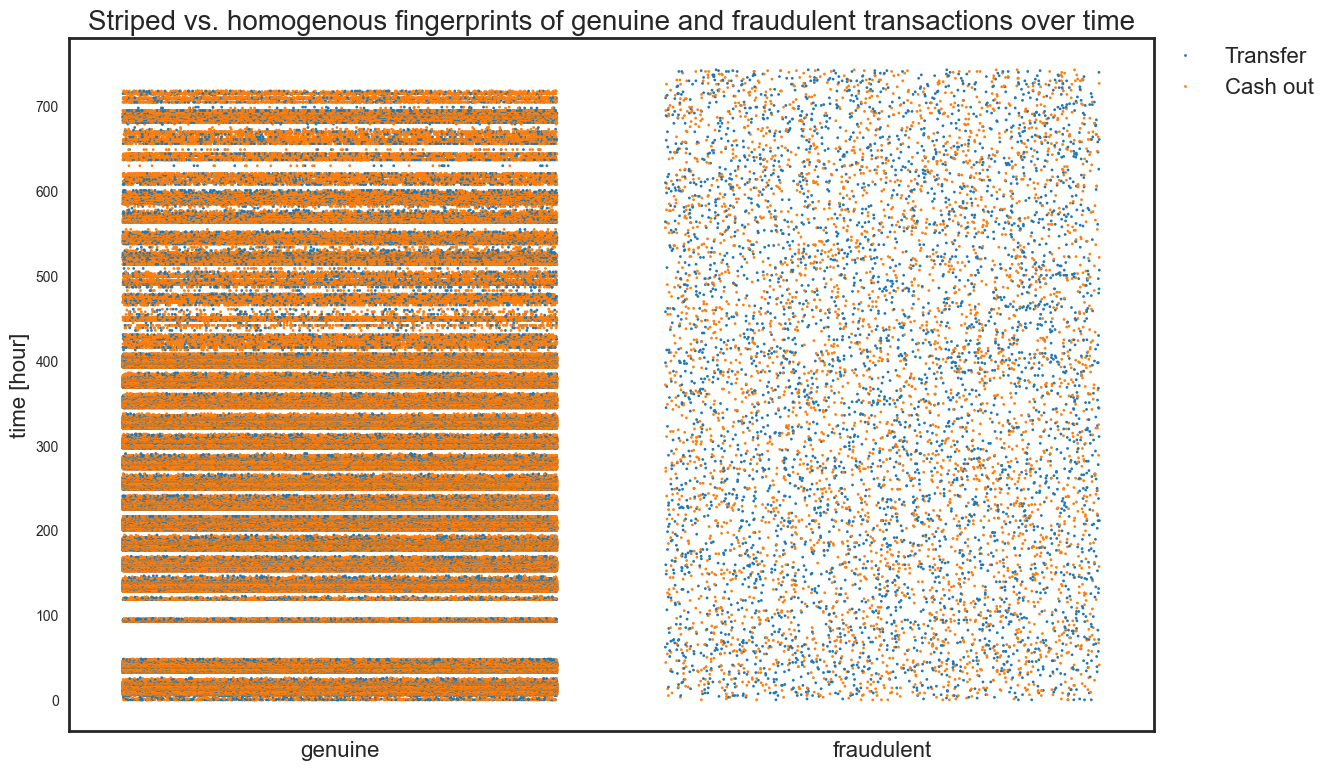

In [21]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent transactions over time', size = 20)

- 사기 거래가 정상 거래에 비해 시간에 걸쳐 더 균일하게 분포되어 있음이 분명함. 
- 또한 정상 거래에서는 인출(CASH-OUT)이 이체(TRANSFER)보다 많은 반면, 사기 거래에서는 양자 간 분포가 균형을 이루고 있음이 확인됨.

-> 사기 거래는 특정 시간대와 무관

##### 5-2. 금액별 분포
사기 거래가 유독 금액(amount)이 큰가?

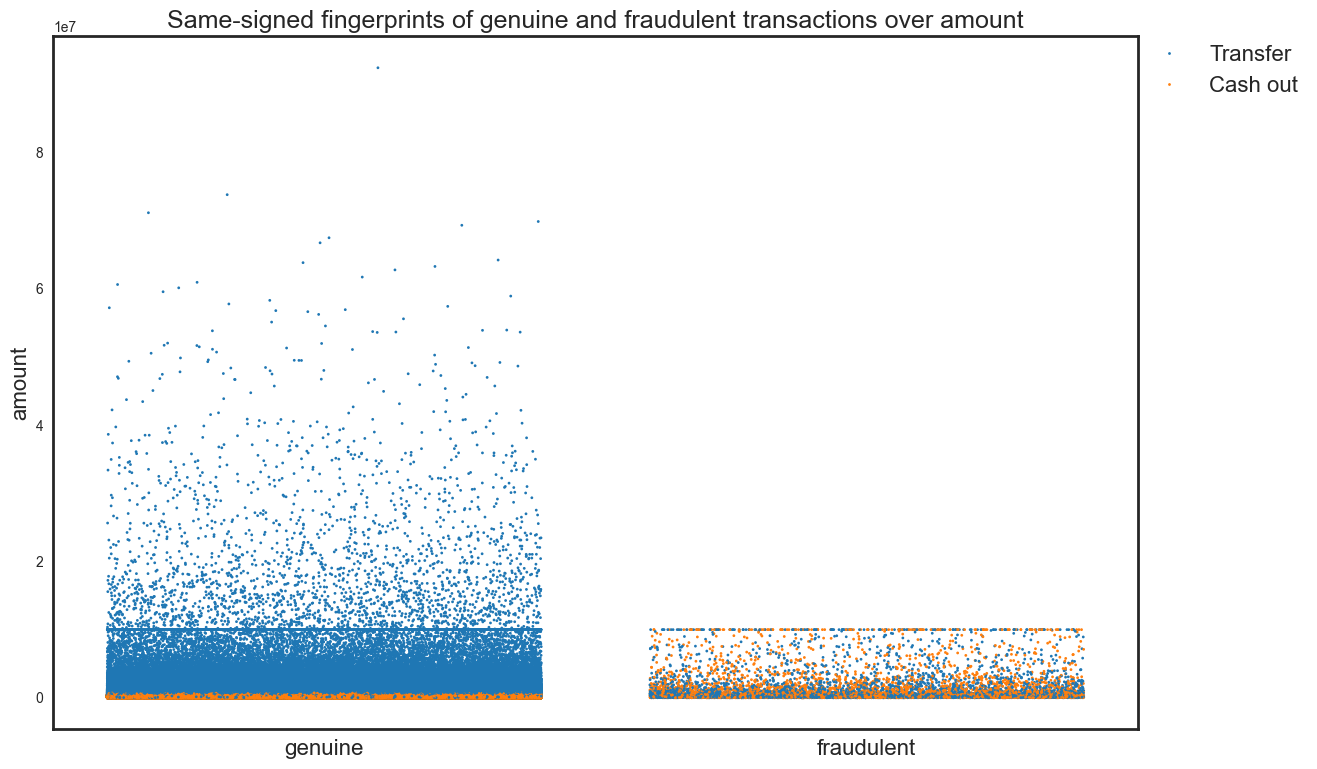

In [22]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);

위 그래프를 보면 사기 거래(Fraudulent)도 대부분의 데이터가 정상 거래(Genuine)와 비슷한 금액대에 겹쳐서(Overlapping) 분포하고 있다.
 즉, **"단순히 거래 금액(amount)이 크다고 해서 사기인 것은 아니다"** 라는 결론이 나옵니다.

##### 5-3. 수신 계좌 잔액 오차(errorBalanceDest)에 따른 분산

정상 거래와 사기 거래의 피처 간 상관관계 패턴(Fingerprint)이 서로 다른지 확인한다.

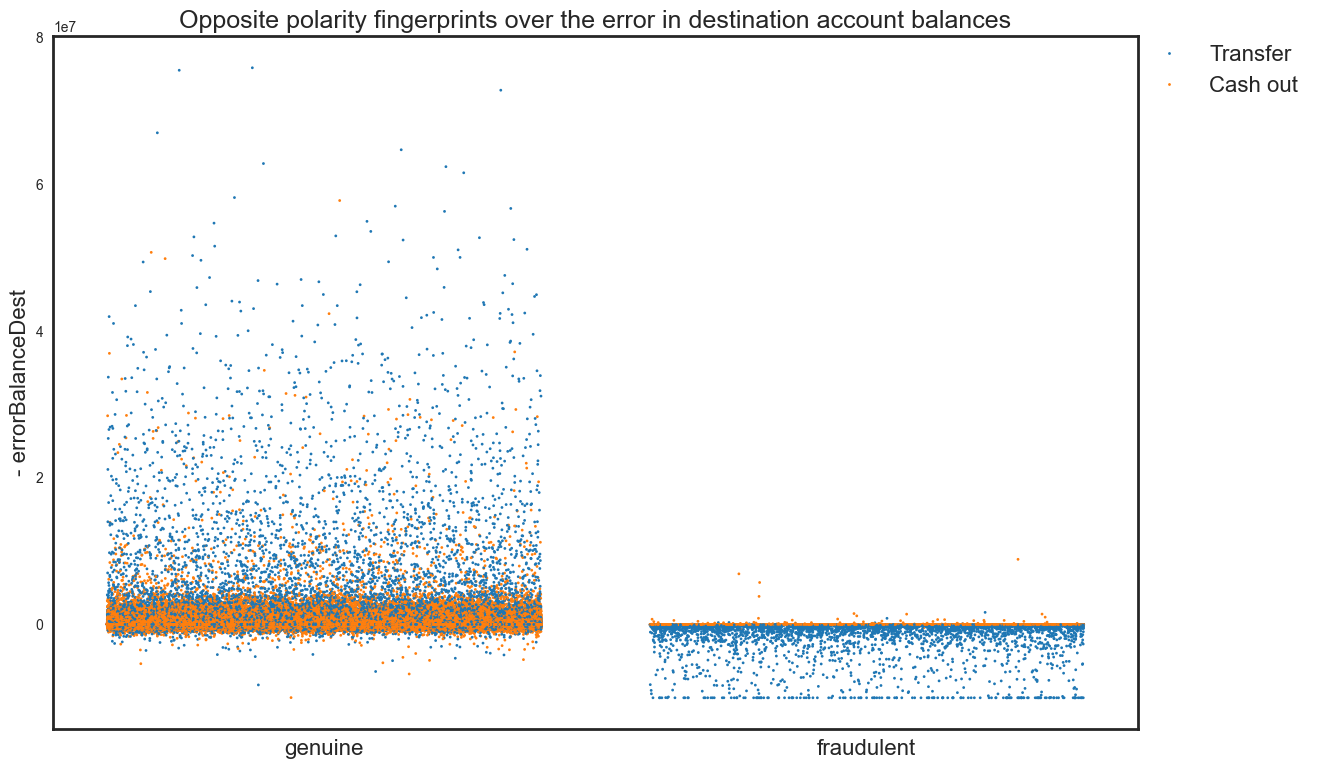

In [23]:
limit = len(X)
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);

이 그래프는 **"완전한 양극화(Opposite Polarity)"** 를 보여주는 매우 중요한 증거다.
- 정상 거래(Genuine): Y축 값이 높게 나타납니다. (마이너스를 붙였으므로 실제로는 음수(-) 오차를 가진다.)

- 사기 거래(Fraudulent): Y축 값이 낮게, 심지어 0 근처와 아래로 강하게 밀집되어 있습니다. (마이너스를 붙였으므로 실제로는 큰 양수(+) 오차를 가진다.)


앞서 amount 그래프에서는 정상과 사기가 한 덩어리로 겹쳐 구분이 불가능했지만, 우리가 설계한 파생 변수인 errorBalanceDest를 축으로 사용하자 두 집단의 지문(Fingerprint)이 위/아래로 극명하게 갈라지는 것을 확인할 수 있다.


-> 이것이 바로 우리가 이 파생 변수를 머신러닝의 핵심 피처로 사용해야 하는 이유이다.

##### 5-4. 3D 산점도: 파생변수의 완전 분리력 검증

우리가 만든 두 오차 피처(errorBalanceOrig, errorBalanceDest)와 시간(step)을 축으로 3D 공간에 시각화하여 사기와 정상 거래가 어떻게 분리되는지 확인한다.

(※ 시각화 성능을 위해 정상 데이터는 10만 건만 샘플링하여 렌더링합니다.)

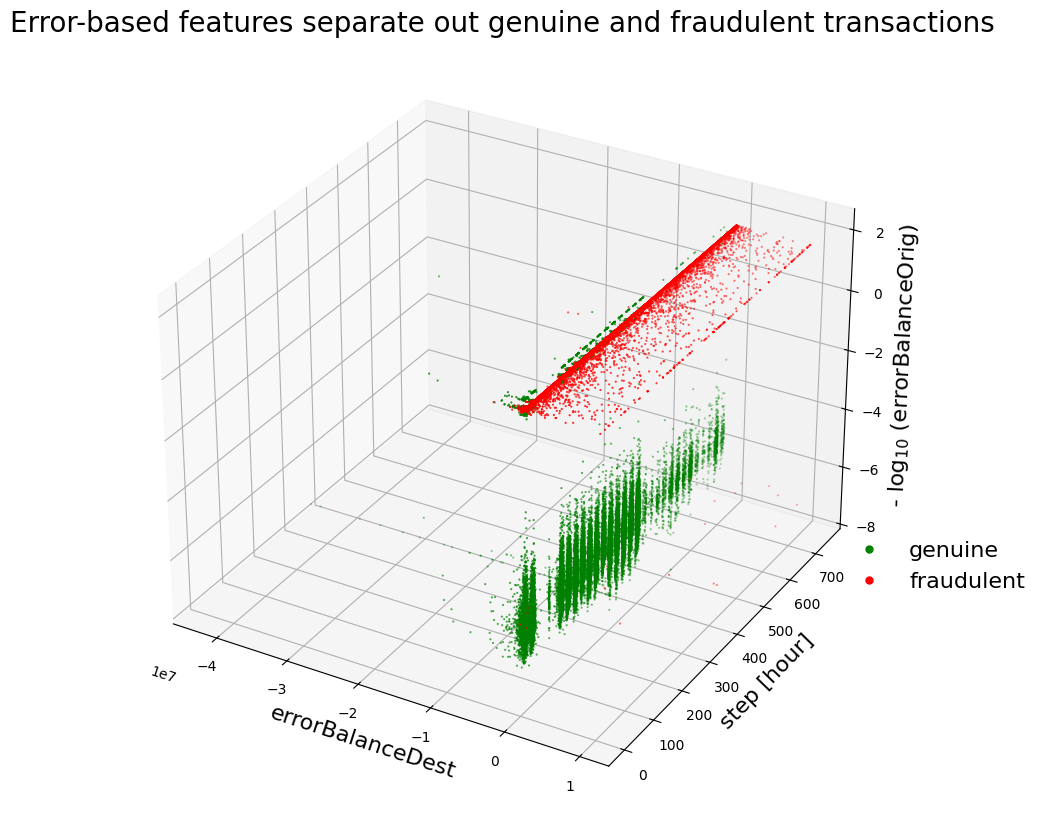

In [29]:
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02

# 메모리 초과를 방지하기 위해 정상 데이터(Genuine)만 10만 건으로 다운샘플링
Xfraud_plot = X.loc[Y == 1]
XnonFraud_plot = X.loc[Y == 0].sample(n=100000, random_state=42)

sns.reset_orig() # seaborn의 3D 그래픽 오버라이딩 방지

fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')

# 정상 거래(초록) 렌더링 (샘플링된 데이터 사용)
ax.scatter(XnonFraud_plot[x], XnonFraud_plot[y],
           -np.log10(XnonFraud_plot[z] + zOffset), c='g', marker='.',
           s=1, label='genuine')
    
# 사기 거래(빨간) 렌더링 (전체 데이터 사용)
ax.scatter(Xfraud_plot[x], Xfraud_plot[y],
           -np.log10(Xfraud_plot[z] + zOffset), c='r', marker='.',
           s=1, label='fraudulent')

ax.set_xlabel(x, size=16)
ax.set_ylabel(y + ' [hour]', size=16)
# Z축은 오차가 클 수록 두드러지게 보이도록 log 스케일 처리
ax.set_zlabel('- log$_{10}$ (' + z + ')', size=16) 
ax.set_title('Error-based features separate out genuine and fraudulent transactions', size=20)

plt.axis('tight')
ax.grid(1)

# 범례 커스텀 생성
noFraudMarker = mlines.Line2D([], [], linewidth=0, color='g', marker='.', markersize=10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth=0, color='r', marker='.', markersize=10, label='fraudulent')

plt.legend(handles=[noFraudMarker, fraudMarker], bbox_to_anchor=(1.20, 0.38), frameon=False, prop={'size': 16})
plt.show()


**빨간점(사기)과 초록점(정상)이 3D 공간상에서 완전히 다른 영역으로 명확하게 갈라진다.**

- Z축(송신 계좌 오차)과 X축(수신 계좌 오차)의 결합이 이 분리의 핵심 축 역할을 수행

- 반면 Y축인 시간(step)의 경우, 초록점과 빨간점이 길게 겹쳐서 기둥(Stripe) 형태로 늘어져 있어 사기를 분리하는 데 전혀 효과가 없음을 알 수 있다.

이 3D 산점도는 **"우리가 설계한 errorBalanceOrig, errorBalanceDest 파생변수가 사기와 정상을 완벽하게 분리해 내는 마스터키"** 임을 직관적이고 시각적으로 증명하는 최종 결과물입니다. 이 데이터를 기반으로 모델링을 수행하면 머신러닝이 극단적 불균형 속에서도 사기를 매우 쉽게 찾아낼 것입니다.

##### 5-5. Fingerprints of genuine and fraudulent transactions" (정상 거래와 사기 거래의 지문 비교) 

새로 만든 피처 errorBalanceOrig, errorBalanceDest 등을 포함해서,


 **"정상 거래일 때 피처 간의 상관관계(Correlation)"** 와 **"사기 거래일 때 피처 간의 상관관계"** 를 비교

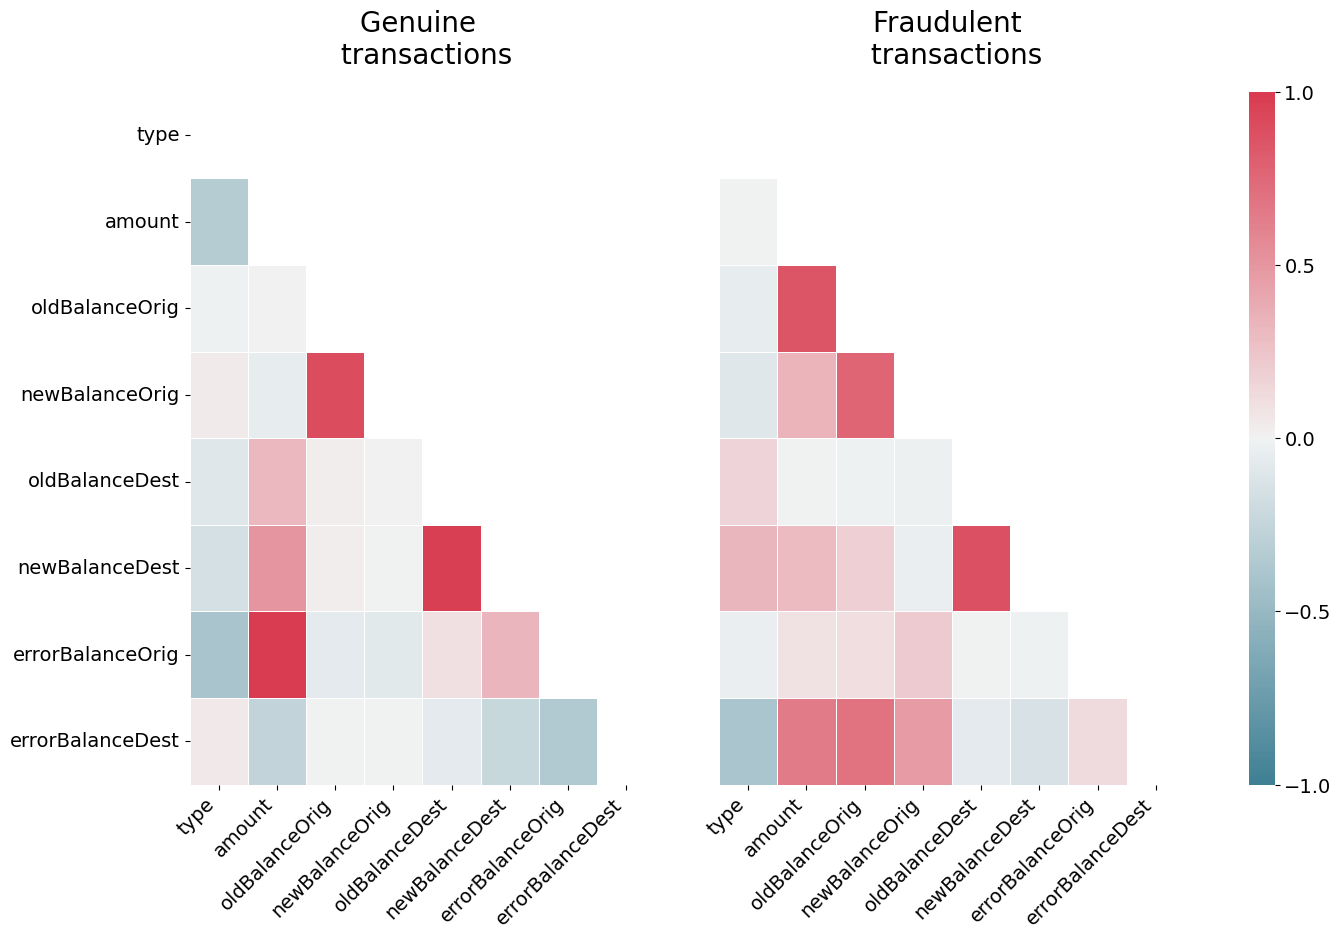

In [30]:
# 업데이트된 X (파생변수가 추가된 상태)를 기반으로 다시 사기/정상 그룹 분리
Xfraud = X.loc[Y == 1].copy()
XnonFraud = X.loc[Y == 0].copy()

# 'step'(시간)은 의미 없으므로 제외하고 상관계수 행렬(Correlation Matrix) 계산
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()

# 히트맵의 위쪽 절반(중복 정보)을 가리기 위한 마스크 생성
mask = np.triu(np.ones_like(correlationNonFraud, dtype=bool))

# 플롯 설정 (좌/우 2개 + 컬러바 1개 비율 조정)
grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, figsize=(14, 9))

# 커스텀 컬러맵 (파랑 ↔ 빨강 계열)
cmap = sns.diverging_palette(220, 8, as_cmap=True)

# 1. 정상 거래(Genuine) 히트맵
sns.heatmap(correlationNonFraud, ax=ax1, vmin=-1, vmax=1, cmap=cmap,
            square=False, linewidths=0.5, mask=mask, cbar=False)
ax1.set_xticklabels(ax1.get_xticklabels(), size=14, rotation=45, ha='right')
ax1.set_yticklabels(ax1.get_yticklabels(), size=14)
ax1.set_title('Genuine \n transactions', size=20, pad=20)

# 2. 사기 거래(Fraudulent) 히트맵
sns.heatmap(correlationFraud, ax=ax2, vmin=-1, vmax=1, cmap=cmap,
            square=False, linewidths=0.5, mask=mask, yticklabels=False,
            cbar_ax=cbar_ax, cbar_kws={'orientation': 'vertical', 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size=14, rotation=45, ha='right')
ax2.set_title('Fraudulent \n transactions', size=20, pad=20)

cbar_ax.tick_params(labelsize=14)
plt.show()


두 히트맵을 나란히 비교해 보면, 정상 데이터와 사기 데이터의 상관관계 뼈대가 근본적으로 다르다는 것을 알 수 있다.

- 정상 거래(왼쪽): oldBalanceOrig와 newBalanceOrig 간의 강한 양의 상관관계(파란색) 등, 특정 피처들끼리 강하게 결합된 패턴을 보인다.

- 사기 거래(오른쪽): 왼쪽과는 전혀 다른 색상 패턴(상관관계 구조)을 띱니다. 특히 amount와 oldBalanceOrig, errorBalanceOrig 간의 강한 결합 등 사기꾼들 특유의 계좌 비우기 패턴이 구조적으로 반영되어 있다.

이 지문(Fingerprint)의 명백한 차이는 우리가 진행한 Feature Engineering이 매우 성공적이었으며, 머신러닝 알고리즘(XGBoost 등)이 이 데이터 구조의 차이를 쉽게 학습할 수 있을 것임을 강력하게 시사함.